In [1]:
%load_ext autoreload
%autoreload 2

from src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os

#torch.autograd.set_detect_anomaly(True) 

### Load Model & Dataset

In [2]:
llama_size = "7b"
use_base_model = True

if not use_base_model:
    model_name_or_path = f"meta-llama/Llama-2-{llama_size}-chat-hf"
else:
    model_name_or_path = f"meta-llama/Llama-2-{llama_size}-hf"

hf_model, hf_tokenizer = load_model_from_transformers(model_name_or_path)
model = from_hf_to_tlens(hf_model, hf_tokenizer, f"llama-{llama_size}", disable_grads=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model llama-7b into HookedTransformer
Moving model to device:  cuda


In [3]:
forget_dataset, forget_dataloader = create_dataset("harry_potter", model.tokenizer, batch_size=32, max_seq_length=1024)
retain_dataset, retain_dataloader = create_dataset("owt", model.tokenizer, batch_size=32, max_seq_length=512, num_examples=1000)

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

### Train Mask


In [4]:
mask = NeuronLevelMask(model).cuda()

train_mask(
    model=model,
    mask=mask,
    retain_dataloader=retain_dataloader,
    forget_dataloader=forget_dataloader,
    max_gpu_batch_size=4,
    learning_rate=1e-1,
)

  0%|          | 0/50 [00:00<?, ?it/s]

Retain Loss: 1.918, Forget Loss: 0.014, Reg Loss: 0.058: 100%|██████████| 50/50 [05:41<00:00,  6.83s/it]


### Analyze mask

0
239
271
312
359
414
479
549
636
739
835
940
1085
1268
1666


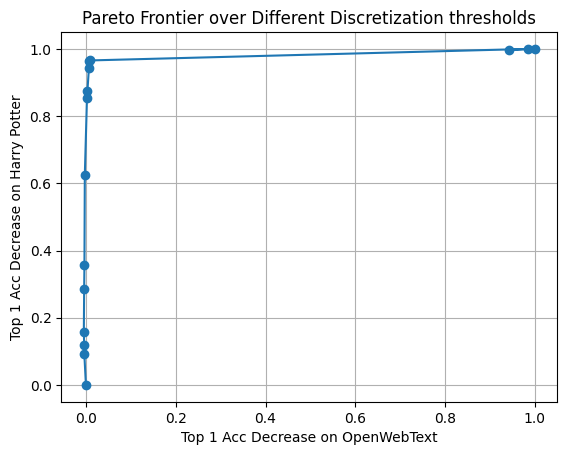

In [7]:
# Compute metrics for different threshold levels
change_over_time = []

for threshold in np.linspace(0, 1, 15):
    mask.discretize_threshold(threshold)
    print(mask.num_masked())
    forget_results = compute_metrics(model, forget_dataloader, verbose=False)
    retain_results = compute_metrics(model, retain_dataloader, verbose=False)
    change_over_time.append((forget_results, retain_results))

# Generate pareto plot using results

initial_x = change_over_time[0][0]["summary"]["top1_acc"]
initial_y = change_over_time[0][1]["summary"]["top1_acc"]

points = []

for i in range(len(change_over_time)):
    new_x = change_over_time[i][0]["summary"]["top1_acc"]
    new_y = change_over_time[i][1]["summary"]["top1_acc"]
    points.append(( (initial_x - new_x)/initial_x, (initial_y - new_y)/initial_y ))
    
points = np.array(points)

plt.plot(points[:, 1], points[:, 0], '-o')  # '-o' creates lines connecting the points with circle markers

# Label the axes
plt.xlabel("Top 1 Acc Decrease on OpenWebText")
plt.ylabel("Top 1 Acc Decrease on Harry Potter")

# Optional: Add a title
plt.title("Pareto Frontier over Different Discretization thresholds")

# Show grid to better visualize the trade-offs
plt.grid(True)

# Show the plot
plt.show()



In [8]:
for i in range(len(change_over_time)):
    forget_acc = change_over_time[i][0]["summary"]["top1_acc"]
    retain_acc = change_over_time[i][1]["summary"]["top1_acc"]
    print(forget_acc, retain_acc)

0.7573809425036112 0.5666112688279921
0.6885417501131693 0.5686063016614606
0.666601320107778 0.5688129817285845
0.6384202440579733 0.5692586514257616
0.5408049623171488 0.5688252487490254
0.4876258273919423 0.5684866174574821
0.2837749421596527 0.568000316619873
0.11111627519130707 0.5652970960063319
0.09375615666309993 0.5646935874415983
0.04294595246513685 0.5628111996958333
0.028070654720067978 0.5626308168134382
0.02596376370638609 0.5614582665504948
0.0 0.008166879776024049
0.0015576323494315147 0.03329415210793095
0.0 0.0002518298091261738


0
0
249
499
749
799
899
999
1499
1666


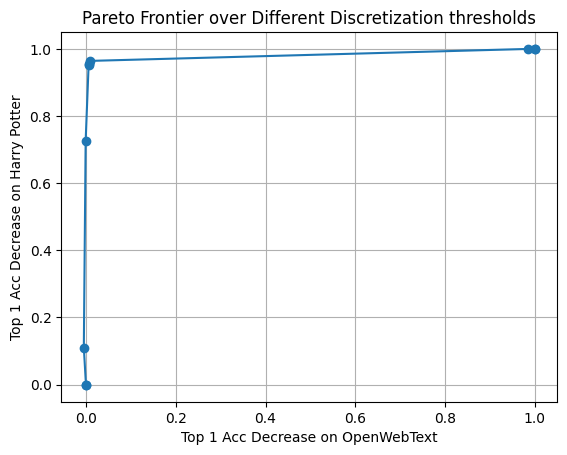

In [15]:
# Compute metrics for different threshold levels
change_over_time = []

for topk in [0, 100, 250, 500, 750, 800, 900, 1_000, 1_500, 2_000]:        
    mask.discretize_topk(topk)
    print(mask.num_masked())
    forget_results = compute_metrics(model, forget_dataloader, verbose=False)
    retain_results = compute_metrics(model, retain_dataloader, verbose=False)
    change_over_time.append((forget_results, retain_results))

# Generate pareto plot using results

initial_x = change_over_time[0][0]["summary"]["top1_acc"]
initial_y = change_over_time[0][1]["summary"]["top1_acc"]

points = []

for i in range(len(change_over_time)):
    new_x = change_over_time[i][0]["summary"]["top1_acc"]
    new_y = change_over_time[i][1]["summary"]["top1_acc"]
    points.append(( (initial_x - new_x)/initial_x, (initial_y - new_y)/initial_y ))
    
points = np.array(points)

plt.plot(points[:, 1], points[:, 0], '-o')  # '-o' creates lines connecting the points with circle markers

# Label the axes
plt.xlabel("Top 1 Acc Decrease on OpenWebText")
plt.ylabel("Top 1 Acc Decrease on Harry Potter")

# Optional: Add a title
plt.title("Pareto Frontier over Different Discretization thresholds")

# Show grid to better visualize the trade-offs
plt.grid(True)

# Show the plot
plt.show()



In [16]:
for i in range(len(change_over_time)):
    forget_acc = change_over_time[i][0]["summary"]["top1_acc"]
    retain_acc = change_over_time[i][1]["summary"]["top1_acc"]
    print(forget_acc, retain_acc)

0.7610166072845459 0.5666296866632277
0.7617630163828532 0.5665589359498793
0.6769503553708395 0.5692710472691443
0.20806531111399332 0.5669584947247659
0.034134890884160995 0.5631672067026938
0.03610918608804544 0.5629081956801876
0.02718413434922695 0.5620358567084035
0.0 0.00818480784073472
0.0 0.00025952228198518915
0.0 0.00025170535081997514


In [12]:
change_over_time[i][0]["summary"]

{'loss_mean': 9.6875,
 'loss_var': 0.018229166666666668,
 'top1_acc': 0.0,
 'top1_var': 0.0}

In [ ]:
torch.kthvalue(torch.tensor([0, 1, 2, 4, ][::-1]), 4).values

tensor(4)